#### Source code credit [scikit-learn example](https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py)

modified to work on the BeeeRecipes dataset

In [ ]:
%matplotlib inline

#### we don't need to corrupt the dataset as the `MashThickness` column already contains missing values

### this notebook exemplifies the use of the `IterativeImputer` from scikit. This is an experimental implementation of the MICE algorithm

## Left as exercise: apply the KNN algorithm (`KNNImputer`) and compare the results

In [1]:
import numpy as np
import pandas as pd

pd.set_option('max_columns', None)
df = pd.read_csv("https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/BEERS-dataset/recipeData.csv", encoding='latin-1').set_index("BeerID")

# X_diabetes, y_diabetes = load_diabetes(return_X_y=True, as_frame=True)  ##show df with column names

df.shape

(73861, 22)

In [2]:
df.head()

,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
BeerID,,,,,,,,,,,,,,,,,,,,,,
1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,28.39,75,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,24.61,60,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0
3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,8.98,22.71,60,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,8.50,26.50,60,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,4.57,60.00,90,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0


In [3]:
## only keep the columns on which we apply regression
dfc = (df.drop(['PrimingMethod', 'PrimingAmount', 'UserId', 'PitchRate', 'PrimaryTemp', 'StyleID', 'Name', 'URL'], axis='columns'))
dfc.head()

,Style,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod
BeerID,,,,,,,,,,,,,,
1,Cream Ale,21.77,1.055,1.013,5.48,17.65,4.83,28.39,75,1.038,70.0,NaN,Specific Gravity,All Grain
2,Holiday/Winter Special Spiced Beer,20.82,1.083,1.021,8.16,60.65,15.64,24.61,60,1.070,70.0,NaN,Specific Gravity,All Grain
3,American IPA,18.93,1.063,1.018,5.91,59.25,8.98,22.71,60,NaN,70.0,NaN,Specific Gravity,extract
4,American IPA,22.71,1.061,1.017,5.80,54.48,8.50,26.50,60,NaN,70.0,NaN,Specific Gravity,All Grain
5,Belgian Blond Ale,50.00,1.060,1.010,6.48,17.84,4.57,60.00,90,1.050,72.0,NaN,Specific Gravity,All Grain


In [4]:
### count the % of missing values in MashThickness
dfc['MashThickness'].isnull().sum()  / len(dfc)


0.4043270467499763

In [5]:
### encode categorical variables SugarScale, Style, BrewMethod

## for Style, only retain the most common styles (see original notebook for regression example using this dataset)
## all other styles are labelled "other"

beer_Style_encoded = (pd.get_dummies(df['Style']))
frequent_styles = beer_Style_encoded.sum(axis='rows') > (len(dfc) / 50)
popular_beer_styles = frequent_styles.where(lambda v: v).dropna().index.values

dfc_encoded = dfc.pipe(lambda df: df.join(pd.get_dummies(df['BrewMethod'], prefix='BrewMethod')) \
               .pipe(lambda df: df.join(pd.get_dummies(df['SugarScale'], prefix='SugarScale'))) \
               .pipe(lambda df: df.assign(Style=df['Style'].map(lambda s: s if s in popular_beer_styles else 'Other'))) \
               .pipe(lambda df: df.join(pd.get_dummies(df['Style'], prefix='Style'))) \
               .drop(['BrewMethod', 'SugarScale', 'Style'], axis='columns'))

dfc_encoded

,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract,SugarScale_Plato,SugarScale_Specific Gravity,Style_American Amber Ale,Style_American IPA,Style_American Light Lager,Style_American Pale Ale,Style_Blonde Ale,Style_Imperial IPA,Style_Other,Style_Saison
BeerID,,,,,,,,,,,,,,,,,,,,,,,,,
1,21.77,1.055,1.013,5.48,17.65,4.83,28.39,75,1.038,70.0,NaN,1,0,0,0,0,1,0,0,0,0,0,0,1,0
2,20.82,1.083,1.021,8.16,60.65,15.64,24.61,60,1.070,70.0,NaN,1,0,0,0,0,1,0,0,0,0,0,0,1,0
3,18.93,1.063,1.018,5.91,59.25,8.98,22.71,60,NaN,70.0,NaN,0,0,0,1,0,1,0,1,0,0,0,0,0,0
4,22.71,1.061,1.017,5.80,54.48,8.50,26.50,60,NaN,70.0,NaN,1,0,0,0,0,1,0,1,0,0,0,0,0,0
5,50.00,1.060,1.010,6.48,17.84,4.57,60.00,90,1.050,72.0,NaN,1,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73857,21.00,1.052,1.012,5.22,39.73,6.96,18.00,60,1.060,63.0,3.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
73858,10.00,1.059,1.010,6.37,59.21,7.90,17.00,60,1.034,60.0,NaN,0,1,0,0,0,1,0,0,0,0,0,0,1,0
73859,16.00,1.046,1.008,5.01,25.42,3.63,18.00,90,1.041,65.0,NaN,0,1,0,0,0,1,0,0,0,0,0,0,1,0


#### now we are ready to impute MashThickness values

In [6]:
## tech step: save the dfc header as the imputer returns an array, from which we build a new pandas df
c = dfc_encoded.columns

In [7]:
# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

imputer = IterativeImputer(missing_values=np.nan, add_indicator=False,
                               random_state=0, n_nearest_features=5,
                               sample_posterior=True)
imputer.fit(dfc_encoded)




IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=5, random_state=0,
                 sample_posterior=True, skip_complete=False, tol=0.001,
                 verbose=0)

In [8]:
imputed_array = imputer.transform(dfc_encoded)

In [9]:
imputed_array


array([[21.77 ,  1.055,  1.013, ...,  0.   ,  1.   ,  0.   ],
       [20.82 ,  1.083,  1.021, ...,  0.   ,  1.   ,  0.   ],
       [18.93 ,  1.063,  1.018, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [16.   ,  1.046,  1.008, ...,  0.   ,  1.   ,  0.   ],
       [24.   ,  1.051,  1.014, ...,  0.   ,  1.   ,  0.   ],
       [20.   ,  1.06 ,  1.01 , ...,  0.   ,  0.   ,  0.   ]])

In [10]:
df_imputed = pd.DataFrame(data=imputed_array, columns=c)

In [11]:
df_imputed

,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract,SugarScale_Plato,SugarScale_Specific Gravity,Style_American Amber Ale,Style_American IPA,Style_American Light Lager,Style_American Pale Ale,Style_Blonde Ale,Style_Imperial IPA,Style_Other,Style_Saison
0,21.77,1.055,1.013,5.48,17.65,4.83,28.39,75.0,1.038000,70.0,-0.082708,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.82,1.083,1.021,8.16,60.65,15.64,24.61,60.0,1.070000,70.0,-0.934095,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,18.93,1.063,1.018,5.91,59.25,8.98,22.71,60.0,0.830721,70.0,1.891585,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22.71,1.061,1.017,5.80,54.48,8.50,26.50,60.0,-0.368036,70.0,5.213871,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50.00,1.060,1.010,6.48,17.84,4.57,60.00,90.0,1.050000,72.0,1.641614,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73856,21.00,1.052,1.012,5.22,39.73,6.96,18.00,60.0,1.060000,63.0,3.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73857,10.00,1.059,1.010,6.37,59.21,7.90,17.00,60.0,1.034000,60.0,-0.965692,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73858,16.00,1.046,1.008,5.01,25.42,3.63,18.00,90.0,1.041000,65.0,0.837549,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73859,24.00,1.051,1.014,4.82,25.65,14.12,28.00,60.0,1.043000,72.0,1.795506,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### how good is the imputation?  let's plot the distribution of the original values for MashThickness and the new distribution considering all imputed values

In [12]:
## summary stats for the variable, before imputation

dfc_encoded.describe()['MashThickness']

count    43997.000000
mean         2.127235
std          1.682347
min          0.000000
25%          1.500000
50%          1.500000
75%          3.000000
max        100.000000
Name: MashThickness, dtype: float64

In [13]:
df_imputed.describe()['MashThickness']

count    73861.000000
mean         2.126336
std          1.681421
min         -4.290095
25%          1.350000
50%          1.600000
75%          3.000000
max        100.000000
Name: MashThickness, dtype: float64

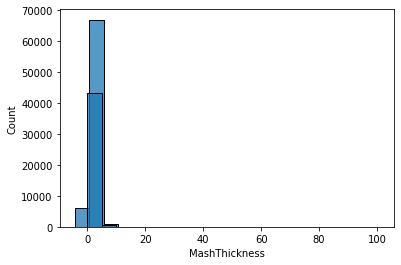

In [15]:
import seaborn as sns

sns.histplot(df_imputed['MashThickness'], binwidth=5)
sns.histplot(df['MashThickness'],binwidth=5)